## Patch Approach to Oyster Classification

Import all needed packages

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers import Input
import tensorflow as tf
import cv2
import numpy as np
import csv
import os
import random
import matplotlib.pyplot as plt

Using TensorFlow backend.


### inspect data and augmentation method

In [234]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order


In [4]:
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

augmentation = iaa.Sometimes(.667, iaa.Sequential([
        iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.25.
        # But we only blur about 50% of all images.
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.ContrastNormalization((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2)),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-180, 180),
            #shear=(-8, 8)
        )
    ], random_order=True)) # apply augmenters in random order

In [24]:
from keras.applications.densenet import preprocess_input

data_dir = '../data/patch/'

with open(data_dir + 'labels/img_labels.csv', newline='') as csvfile:
    labels_csv = csv.reader(csvfile, delimiter=',', quotechar='|')
    labels_list = list(labels_csv)
    labels_list.pop(0) # get rid of metadata 

random.shuffle(labels_list)

i=0

image_batch = np.zeros((36, 299, 299, 3))
label_batch = np.zeros((36,2))

for i in range(15):
    file_name = labels_list[i][0]
    label = np.zeros((1,2))
    label_batch[i][int(labels_list[i][-1])] = 1
    image = cv2.resize(cv2.imread(data_dir + 'images/' + file_name), (299,299))
    #image = augmentation.augment_image(image)
    image = preprocess_input(image)
    #image = (image.astype(float) - 128) / 128
    image_batch[i] = image

In [25]:
print(np.amax(image))
print(np.amin(image))
print(image.shape)

2.4308496
-0.06293353
(299, 299, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

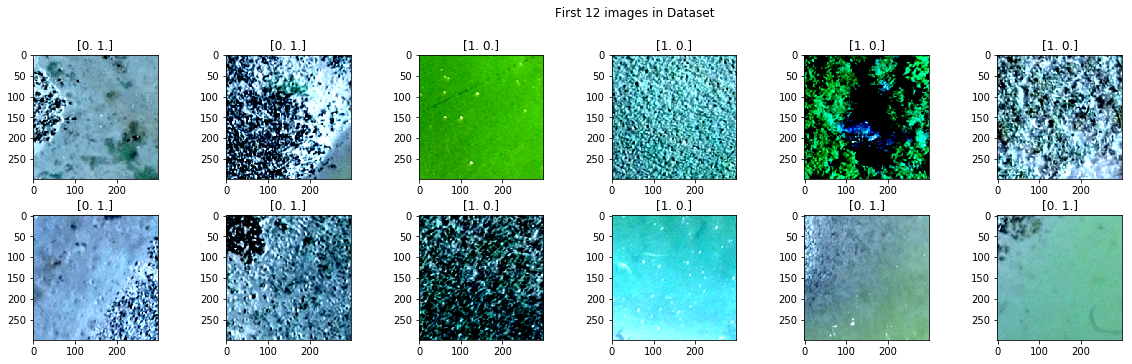

In [23]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5)) 

for i in range(6):
    axs[0,i].imshow(image_batch[i])
    axs[0,i].set_title(label_batch[i])
    
for i in range(6,12):
    axs[1,i-6].imshow(image_batch[i])
    axs[1,i-6].set_title(label_batch[i])
    
fig.suptitle('First 12 images in Dataset')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])

### data generator for all models

In [27]:
def generate_data(directory, batch_size, dataset='train',augment=True):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    with open(directory + 'labels/' + dataset + '/img_labels.csv', newline='') as csvfile:
        labels_csv = csv.reader(csvfile, delimiter=',', quotechar='|')
        labels_list = list(labels_csv)
        labels_list.pop(0) # get rid of metadata
    
    #random.shuffle(labels_list)
        
    while True:
        image_batch = np.zeros((batch_size, 224, 224, 3))
        label_batch = np.zeros((batch_size,2))
        
        for b in range(batch_size):
            #print(b)
            if i == len(labels_list):
                i = 0
                random.shuffle(labels_list)
                file_name = labels_list[i][0]
                
            # add label to the batch
            label_batch[b][int(labels_list[i][-1])] = 1
                
            # add image to the batch
            file_name = labels_list[i][0]
            #print(data_dir + sample)
            image = cv2.resize(cv2.imread(data_dir + 'images/' + file_name), (224,224))
            if augment:
                image = augmentation.augment_image(image)
            image = preprocess_input(image)
            #image = (image.astype(float) - 128) / 128
            image_batch[b] = image
            i += 1
        yield (image_batch, label_batch)

In [ ]:
data_gen = generate_data(data_dir, 12, augment=False)
image_batch, label_batch = next(data_gen)

In [ ]:
data_gen = generate_data(data_dir, 12, augment=False)
image_batch, label_batch = next(data_gen)

fig, axs = plt.subplots(2, 6, figsize=(18, 5)) 

for i in range(6):
    axs[0,i].imshow(image_batch[i])
    axs[0,i].set_title(label_batch[i])
    
for i in range(6,12):
    axs[1,i-6].imshow(image_batch[i])
    axs[1,i-6].set_title(label_batch[i])
    
fig.suptitle('First 12 images in Dataset')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])

### InceptionV3 Fine-Tuning

In [168]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

In [169]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [170]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [172]:
K.set_session(tf.Session(graph=model.output.graph)) 
init = K.tf.global_variables_initializer() 
K.get_session().run(init)

In [173]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

batch_size = 20
INPUT_SHAPE = (299,299)
data_dir = '../data/patch/'

# train the model on the new data for a few epochs
model.fit_generator(
    generate_data(data_dir, batch_size),
    len(os.listdir(data_dir + 'images/')) // batch_size,
    epochs=20)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/20
200/200 [==============================] - 28s 141ms/step - loss: 9.01430s - loss: 9.
Epoch 2/20
200/200 [==============================] - 19s 94ms/step - loss: 9.0463
Epoch 3/20
200/200 [==============================] - 19s 97ms/step - loss: 9.0664
Epoch 4/20
200/200 [==============================] - 19s 97ms/step - loss: 9.0261
Epoch 5/20
200/200 [==============================] - 19s 97ms/step - loss: 9.0503
Epoch 6/20
200/200 [==============================] - 20s 98ms/step - loss: 9.0705
Epoch 7/20
200/200 [==============================] - 19s 97ms/step - loss: 9.0423
Epoch 8/20
200/200 [==============================] - 20s 98ms/step - loss: 9.0423
Epoch 9/20
200/200 [==============================] - 20s 98ms/step - loss: 9.0543
Epoch 10/20
200/200 [==============================] - 20s 98ms/step - loss: 9.0181
Epoch 11/20
200/200 [==============================] - 19s 96ms/step - loss: 9.0906
Epoch 12/20
200/200 [==============================] - 19s 97ms/step - 

In [174]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

0 input_4
1 conv2d_283
2 batch_normalization_283
3 activation_283
4 conv2d_284
5 batch_normalization_284
6 activation_284
7 conv2d_285
8 batch_normalization_285
9 activation_285
10 max_pooling2d_13
11 conv2d_286
12 batch_normalization_286
13 activation_286
14 conv2d_287
15 batch_normalization_287
16 activation_287
17 max_pooling2d_14
18 conv2d_291
19 batch_normalization_291
20 activation_291
21 conv2d_289
22 conv2d_292
23 batch_normalization_289
24 batch_normalization_292
25 activation_289
26 activation_292
27 average_pooling2d_28
28 conv2d_288
29 conv2d_290
30 conv2d_293
31 conv2d_294
32 batch_normalization_288
33 batch_normalization_290
34 batch_normalization_293
35 batch_normalization_294
36 activation_288
37 activation_290
38 activation_293
39 activation_294
40 mixed0
41 conv2d_298
42 batch_normalization_298
43 activation_298
44 conv2d_296
45 conv2d_299
46 batch_normalization_296
47 batch_normalization_299
48 activation_296
49 activation_299
50 average_pooling2d_29
51 conv2d_295
52

In [175]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    generate_data(data_dir, batch_size),
    len(os.listdir(data_dir + 'images/')) // batch_size,
    epochs=50)

Epoch 1/50
200/200 [==============================] - 33s 167ms/step - loss: 9.0463
Epoch 2/50
200/200 [==============================] - 22s 110ms/step - loss: 9.0302
Epoch 3/50
200/200 [==============================] - 22s 109ms/step - loss: 9.0664
Epoch 4/50
177/200 [=========================>....] - ETA: 2s - loss: 9.1063

KeyboardInterrupt: 

### Moving to MobileNet

In [264]:
from keras.applications.mobilenet_v2 import MobileNetV2

# create the base pre-trained model
base_model = MobileNetV2(weights=None, include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    generate_data(data_dir, batch_size, augment=False),
    len(os.listdir(data_dir + 'images/')) // batch_size,
    epochs=20,
    validation_data=generate_data(data_dir, batch_size, 'val'),
    validation_steps= 700 // batch_size,
    #callbacks=callbacks_list
)

Epoch 1/20
404/404 [==============================] - 109s 269ms/step - loss: 0.6576 - acc: 0.6203 - val_loss: 0.7352 - val_acc: 0.5943
Epoch 2/20
404/404 [==============================] - 58s 143ms/step - loss: 0.5742 - acc: 0.7063 - val_loss: 0.7821 - val_acc: 0.6400
Epoch 3/20
404/404 [==============================] - 59s 145ms/step - loss: 0.5361 - acc: 0.7259 - val_loss: 0.7128 - val_acc: 0.6771
Epoch 4/20
404/404 [==============================] - 59s 147ms/step - loss: 0.5157 - acc: 0.7431 - val_loss: 0.7825 - val_acc: 0.6514
Epoch 5/20
404/404 [==============================] - 59s 146ms/step - loss: 0.4921 - acc: 0.7520 - val_loss: 0.8846 - val_acc: 0.6629
Epoch 6/20
404/404 [==============================] - 59s 147ms/step - loss: 0.4705 - acc: 0.7679 - val_loss: 1.4371 - val_acc: 0.6414
Epoch 7/20
369/404 [==========================>...] - ETA: 4s - loss: 0.4565 - acc: 0.7798

KeyboardInterrupt: 

### Fine-Tuning MobileNet

In [193]:
base_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [194]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [195]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_7
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_exp

In [196]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:35]:
    layer.trainable=False
for layer in model.layers[35:]:
    layer.trainable=True

In [13]:
from keras.optimizers import SGD

# compile the mode with the Adam optimizer, loss function will be categorical,
# cross entropy and evaluation metric will be accuracy
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy',metrics=['accuracy'])

batch_size = 20
INPUT_SHAPE = (224,224)
data_dir = '../data/patch/'

# set the model up to save the best weights based on val_loss
#filepath="../data/patch/logs/mobilenet--{epoch:02d}-{val_loss:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]


model.fit_generator(
    generate_data(data_dir, batch_size),
    len(os.listdir(data_dir + 'images/')) // batch_size / 2,
    epochs=20,
    validation_data=generate_data(data_dir, batch_size, 'val'),
    validation_steps= 700 // batch_size / 2,
    #callbacks=callbacks_list
)

Epoch 1/20
202/202 [==============================] - 28s 138ms/step - loss: 0.7113 - acc: 0.4876 - val_loss: 0.6928 - val_acc: 0.5556
Epoch 2/20
202/202 [==============================] - 25s 122ms/step - loss: 0.7082 - acc: 0.4881 - val_loss: 0.6855 - val_acc: 0.5778
Epoch 3/20
 98/202 [=============>................] - ETA: 12s - loss: 0.7078 - acc: 0.5051

KeyboardInterrupt: 

### Testing DenseNet

In [300]:
from keras.applications.densenet import DenseNet121

# create the base pre-trained model
base_model = DenseNet121(weights=None, include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    generate_data(data_dir, batch_size, augment=False),
    len(os.listdir(data_dir + 'images/')) // batch_size,
    epochs=20,
    validation_data=generate_data(data_dir, batch_size, 'val'),
    validation_steps= 700 // batch_size,
    #callbacks=callbacks_list
)

Epoch 1/20


KeyboardInterrupt: 

### Fine Tuning DenseNet

In [54]:
from keras.applications.densenet import DenseNet121
from keras.optimizers import SGD

base_model=DenseNet121(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(256,activation='relu')(x) #dense layer 3
predictions=Dense(2,activation='softmax')(x) #final layer with softmax activation

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [55]:
for i,layer in enumerate(base_model.layers):
    print(i,layer.name)

0 input_4
1 zero_padding2d_7
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_8
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [56]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers
for layer in base_model.layers:
    layer.trainable=False

# or if we want to set the first 20 layers of the network to be non-trainable
#for layer in model.layers[:368]:
#    layer.trainable=False
#for layer in model.layers[368:]:
#    layer.trainable=True

In [57]:
# compile the mode with the Adam optimizer, loss function will be categorical,
# cross entropy and evaluation metric will be accuracy
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy',metrics=['accuracy'])

batch_size = 10
INPUT_SHAPE = (224,224)
data_dir = '../data/patch/'

# set the model up to save the best weights based on val_loss
#filepath="../data/patch/logs/mobilenet--{epoch:02d}-{val_loss:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

model.fit_generator(
    generate_data(data_dir, batch_size, augment=False),
    len(os.listdir(data_dir + 'images/')) // batch_size / 2,
    epochs=50,
    validation_data=generate_data(data_dir, batch_size, 'val'),
    validation_steps= 700 // batch_size,
    #callbacks=callbacks_list
)

Epoch 1/50
405/404 [==============================] - 32s 79ms/step - loss: 0.5720 - acc: 0.6988 - val_loss: 0.6349 - val_acc: 0.6300
Epoch 2/50
405/404 [==============================] - 20s 49ms/step - loss: 0.4599 - acc: 0.7852 - val_loss: 0.6344 - val_acc: 0.6286
Epoch 3/50
405/404 [==============================] - 20s 49ms/step - loss: 0.4158 - acc: 0.8126 - val_loss: 0.6740 - val_acc: 0.5986
Epoch 4/50
405/404 [==============================] - 20s 49ms/step - loss: 0.4097 - acc: 0.8123 - val_loss: 0.7136 - val_acc: 0.5743
Epoch 5/50
405/404 [==============================] - 20s 49ms/step - loss: 0.3957 - acc: 0.8272 - val_loss: 0.6914 - val_acc: 0.6129
Epoch 6/50
405/404 [==============================] - 20s 49ms/step - loss: 0.3835 - acc: 0.8277 - val_loss: 0.7014 - val_acc: 0.6114
Epoch 7/50
405/404 [==============================] - 21s 51ms/step - loss: 0.3735 - acc: 0.8328 - val_loss: 0.7373 - val_acc: 0.5943
Epoch 8/50
405/404 [==============================] - 20s 50ms

KeyboardInterrupt: 

In [58]:
# now we want to set the first x layers of the network to be non-trainable
for layer in model.layers[:368]:
    layer.trainable=False
for layer in model.layers[368:]:
    layer.trainable=True

In [59]:
# compile the mode with the Adam optimizer, loss function will be categorical,
# cross entropy and evaluation metric will be accuracy
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy',metrics=['accuracy'])

batch_size = 10
INPUT_SHAPE = (224,224)
data_dir = '../data/patch/'

# set the model up to save the best weights based on val_loss
#filepath="../data/patch/logs/mobilenet--{epoch:02d}-{val_loss:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

model.fit_generator(
    generate_data(data_dir, batch_size, augment=False),
    len(os.listdir(data_dir + 'images/')) // batch_size / 2,
    epochs=50,
    validation_data=generate_data(data_dir, batch_size, 'val'),
    validation_steps= 700 // batch_size,
    #callbacks=callbacks_list
)

Epoch 1/50
405/404 [==============================] - 38s 95ms/step - loss: 0.3321 - acc: 0.8588 - val_loss: 1.0350 - val_acc: 0.6014
Epoch 2/50
405/404 [==============================] - 24s 60ms/step - loss: 0.3220 - acc: 0.8553 - val_loss: 1.0649 - val_acc: 0.5986
Epoch 3/50
405/404 [==============================] - 24s 59ms/step - loss: 0.3014 - acc: 0.8748 - val_loss: 1.1621 - val_acc: 0.5943
Epoch 4/50
405/404 [==============================] - 25s 61ms/step - loss: 0.3007 - acc: 0.8686 - val_loss: 0.8930 - val_acc: 0.6300
Epoch 5/50
405/404 [==============================] - 25s 61ms/step - loss: 0.3096 - acc: 0.8637 - val_loss: 1.1842 - val_acc: 0.5771
Epoch 6/50
405/404 [==============================] - 24s 60ms/step - loss: 0.2910 - acc: 0.8738 - val_loss: 1.1530 - val_acc: 0.5971
Epoch 7/50
405/404 [==============================] - 25s 61ms/step - loss: 0.2871 - acc: 0.8793 - val_loss: 1.2012 - val_acc: 0.6000
Epoch 8/50
405/404 [==============================] - 25s 61ms

KeyboardInterrupt: 

In [41]:
def data():
    '''
    Data providing function:
    This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(60000, 784)
    X_test = X_test.reshape(10000, 784)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    nb_classes = 10
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    return X_train, Y_train, X_test, Y_test

In [44]:
from keras.applications.densenet import DenseNet121
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

def model_creator(X_train, Y_train, X_test, Y_test):
    '''
    Model providing function:
    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    '''
    
    base_model=DenseNet121(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense({{choice([256, 512, 1024])}},activation={{choice(['relu', 'sigmoid'])}})(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=Dropout({{uniform(0, 1)}})(x)
    x=Dense({{choice([256, 512, 1024])}},activation={{choice(['relu', 'sigmoid'])}})(x) #dense layer 3
    preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

    model=Model(inputs=base_model.input,outputs=preds)
    #specify the inputs
    #specify the outputs
    #now a model has been created based on our architecture

    # or if we want to set the first 20 layers of the network to be non-trainable
    freeze_point = {{uniform(141,416)}}
    for layer in model.layers[:freeze_point]:
        layer.trainable=False
    for layer in model.layers[freeze_point:]:
        layer.trainable=True

    # compile the mode with the Adam optimizer, loss function will be categorical,
    # cross entropy and evaluation metric will be accuracy
    #model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

    model.compile(optimizer=SGD(lr={{uniform(0.001, 0.00001)}}, momentum=0.9, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy',metrics=['accuracy'])

    batch_size = 30
    data_dir = '../data/patch/'

    # set the model up to save the best weights based on val_loss
    #filepath="../data/patch/logs/mobilenet--{epoch:02d}-{val_loss:.2f}.hdf5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    #callbacks_list = [checkpoint]
    """
    model.fit_generator(
        generator(data_dir, batch_size, augment=False),
        len(os.listdir(data_dir + 'images/')) // batch_size,
        epochs=50,
        validation_data=generator(data_dir, batch_size, 'val'),
        validation_steps= 700 // batch_size,
        #callbacks=callbacks_list
    )
    """
    model.fit(X_train, Y_train,
              batch_size={{choice([64, 128])}},
              nb_epoch=1,
              verbose=2,
              validation_data=(X_test, Y_test))
    score, acc = model.evaluate(X_test, Y_test, verbose=0)

    #score, acc = model.evaluate_generator(generator(data_dir, 20, 'test'))
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [45]:
trials = Trials()
best_run, best_model = optim.minimize(model=model_creator,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=trials,
                                      notebook_name='patch_approach')

X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))

SyntaxError: invalid syntax (<unknown>, line 595)

In [54]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.datasets import mnist
from keras.utils import np_utils

def data():
    '''
    Data providing function:
    This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(60000, 784)
    X_test = X_test.reshape(10000, 784)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    nb_classes = 10
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    return X_train, Y_train, X_test, Y_test


def model(X_train, Y_train, X_test, Y_test):
    '''
    Model providing function:
    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    '''
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense(100))
        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              batch_size={{choice([64, 128])}},
              nb_epoch=1,
              verbose=2,
              validation_data=(X_test, Y_test))
    score, acc = model.evaluate(X_test, Y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

trials = Trials()
best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=trials,
                                      notebook_name='patch_approach')
for trial in trials:
    print(trial)
X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))

>>> Imports:
#coding=utf-8

try:
    from keras.applications.inception_v3 import InceptionV3
except:
    pass

try:
    from keras.preprocessing import image
except:
    pass

try:
    from keras.models import Model
except:
    pass

try:
    from keras.layers import Dense, GlobalAveragePooling2D
except:
    pass

try:
    from keras.callbacks import ModelCheckpoint
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.layers import Input
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import cv2
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import csv
except:
    pass

try:
    import os
except:
    pass

try:
    import random
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from keras.applications.densenet import preprocess_input
except:
    pass

try:
    import imgaug as ia
except:
    pass

try:
    from imgaug import augmenters as iaa
except:
  

SyntaxError: from __future__ imports must occur at the beginning of the file (temp_model.py, line 143)

### Metrics

In [83]:
def check_acc(model, count=50):
    with open(data_dir + 'labels/train/img_labels.csv', newline='') as csvfile:
        labels_csv = csv.reader(csvfile, delimiter=',', quotechar='|')
        labels_list = list(labels_csv)
        labels_list.pop(0) # get rid of metadata 

    random.shuffle(labels_list)

    i=0
    
    wrong_count=0

    while True:
        #if i == len(file_list):
        if i > count:
            break

        file_name = labels_list[i][0]
        label = np.zeros((1,2))
        label[0][int(labels_list[i][-1])] = 1
        image = cv2.resize(cv2.imread(data_dir + 'images/' + file_name), (224,224))
        image_norm = (image.astype(float) - 128) / 128
        image_batch = np.zeros((1, 224, 224, 3))
        image_batch[0] = image_norm

        predicted_label = model.predict(image_batch)
        i += 1
        #print(label[0], predicted_label[0])
        #print(np.argmax(label[0]), np.argmax(predicted_label[0]))
        if np.argmax(label[0]) != np.argmax(predicted_label[0]):
            #print('wrong')
            wrong_count+=1
    print(1 - (wrong_count / count))
    

In [84]:
check_acc(model, 2000)

0.655


In [78]:
str(np.round(predicted_labels[i], 2)) + '-' + str(label_batch[i])

'[0.63 0.37]-[1. 0.]'

In [ ]:
data_gen = generate_data(data_dir, 12, augment=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

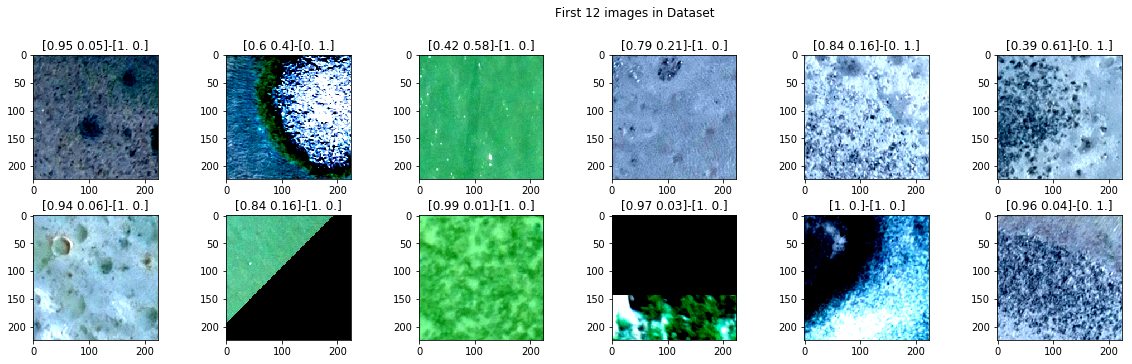

In [81]:
image_batch, label_batch = next(data_gen)

predicted_labels = model.predict(image_batch)

fig, axs = plt.subplots(2, 6, figsize=(18, 5)) 

for i in range(6):
    axs[0,i].imshow(image_batch[i])
    axs[0,i].set_title(str(np.round(predicted_labels[i], 2)) + '-' + str(label_batch[i]))
    
for i in range(6,12):
    axs[1,i-6].imshow(image_batch[i])
    axs[1,i-6].set_title(str(np.round(predicted_labels[i], 2)) + '-' + str(label_batch[i]))
    
fig.suptitle('First 12 images in Dataset')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])

In [310]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [313]:
batch_size = 20
num_classes = 2
epochs = 30
data_augmentation = True
INPUT_SHAPE = (299,299)
data_dir = '../data/patch/'

In [320]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_378 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
activation_377 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_379 (Conv2D)          (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_378 (Activation)  (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_380 (Conv2D)          (None, 111, 111, 64)      18496     
__________

In [324]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)


# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


model.fit_generator(
    generate_data(data_dir, batch_size, augment=False),
    len(os.listdir(data_dir + 'images/')) // batch_size,
    epochs=50,
    validation_data=generate_data(data_dir, batch_size, 'val'),
    validation_steps= 700 // batch_size,
    #callbacks=callbacks_list
)

Epoch 1/50
404/404 [==============================] - 129s 320ms/step - loss: 0.5899 - acc: 0.7297 - val_loss: 0.5518 - val_acc: 0.7257
Epoch 2/50
404/404 [==============================] - 43s 105ms/step - loss: 0.4236 - acc: 0.8151 - val_loss: 0.5819 - val_acc: 0.7257
Epoch 3/50
404/404 [==============================] - 42s 105ms/step - loss: 0.3793 - acc: 0.8365 - val_loss: 0.6150 - val_acc: 0.7257
Epoch 4/50
404/404 [==============================] - 44s 108ms/step - loss: 0.3529 - acc: 0.8520 - val_loss: 0.5860 - val_acc: 0.7057
Epoch 5/50
404/404 [==============================] - 43s 108ms/step - loss: 0.3247 - acc: 0.8624 - val_loss: 0.5818 - val_acc: 0.7043
Epoch 6/50
404/404 [==============================] - 43s 107ms/step - loss: 0.3009 - acc: 0.8756 - val_loss: 0.5772 - val_acc: 0.7114
Epoch 7/50
404/404 [==============================] - 43s 107ms/step - loss: 0.2949 - acc: 0.8834 - val_loss: 0.6292 - val_acc: 0.6900
Epoch 8/50
404/404 [==============================] - 

KeyboardInterrupt: 